In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

# Get the Data

In [402]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()

In [403]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,1076.000000,1076.000000,1.076000e+03,1076.000000,1.076000e+03,1076.000000,1.076000e+03,1.076000e+03
mean,1884.239384,-0.990435,8.281041e-07,-0.000181,3.672905e-07,0.000003,-3.531896e-07,-3.745304e-07
std,1089.383951,0.001026,3.228151e-03,0.000774,2.148905e-03,0.006637,1.596921e-03,8.038508e-07
min,0.000000,-0.991697,-4.563797e-03,-0.001314,-3.268495e-03,-0.009103,-2.401273e-03,-2.843359e-06
25%,942.119700,-0.991471,-3.224363e-03,-0.000942,-1.986743e-03,-0.006574,-1.600085e-03,-8.949463e-07
50%,1884.239500,-0.990592,1.526079e-05,-0.000236,5.841051e-06,-0.000419,-9.748682e-06,-3.095703e-07
75%,2826.359250,-0.989401,3.248570e-03,0.000581,1.975414e-03,0.006472,1.603126e-03,2.357666e-07
max,3768.479000,-0.988843,4.559389e-03,0.001052,3.271815e-03,0.010038,2.396751e-03,1.135547e-06


Notice that dv_vel varies in the range -2e-7 to 1e-7, while dv_st varies in the range -7e-9 to 4e-9, so the MOST COSTLY maneuvers are much larger using CORRECTION_VEL method than using CORRECTION_ST !!

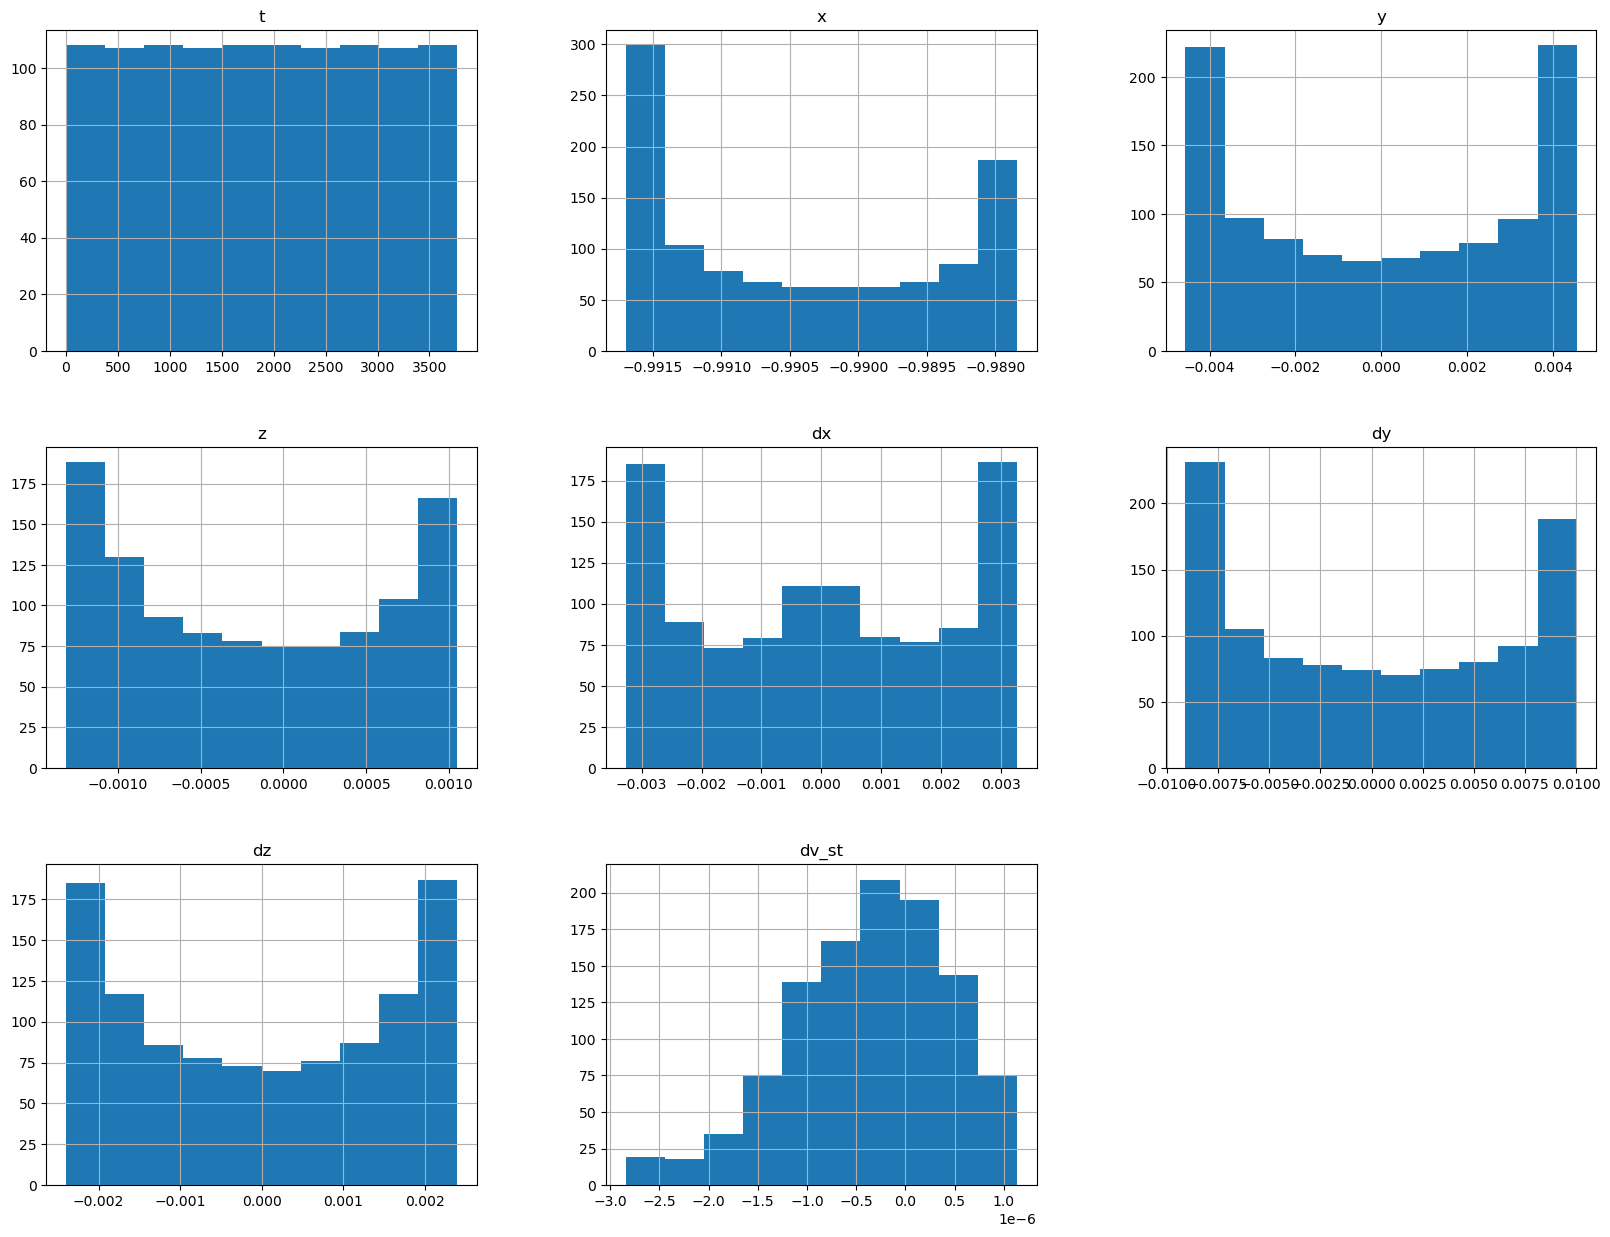

In [404]:
maneuvers.hist(figsize=(20,15))
plt.show()

Histograms of attributes (x,y,z,dx,dy,dz) are tail heavy. We may need to transform to polar coords, or use angle in p.o. as extra attribute.

## Create a Train/Test Set

In [405]:
train_set, test_set = train_test_split(maneuvers, test_size=0.2, random_state=1)

## Visualizing Data

In [406]:
# Let's create a copy of the training set and call it 'maneuvers' again.
# This way we can play around with it without harming the training set.
maneuvers = train_set.copy()
maneuvers.size

6880

In [407]:
# Let's create a copy of the test set and call it 'maneuvers_test'.
# This way we can play around with it without harming the test set.
maneuvers_test = test_set.copy()
maneuvers_test.size

1728

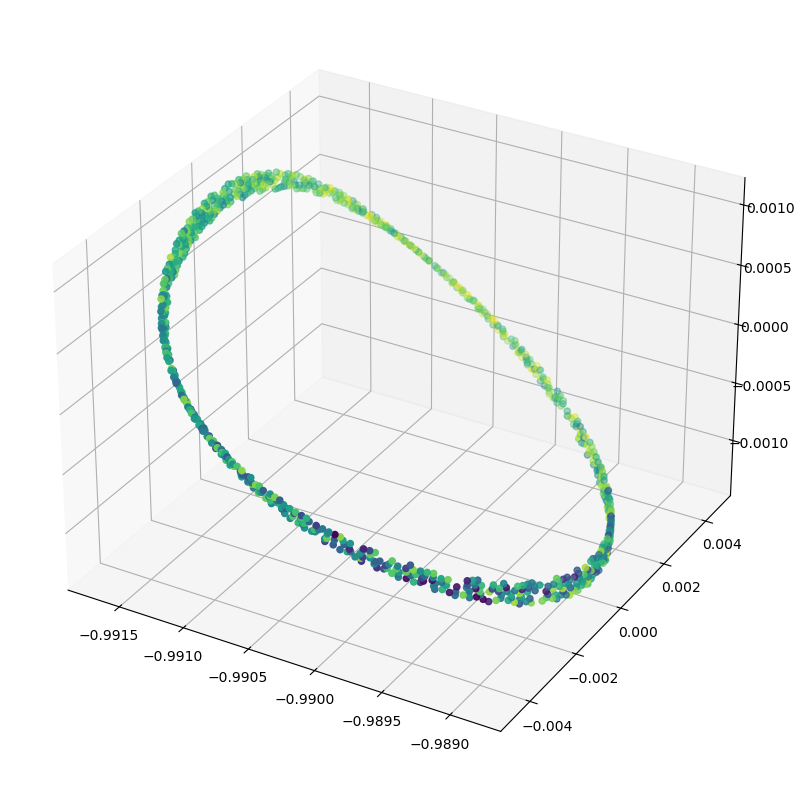

In [408]:
# Visualize shadowing orbit in position space, i.e. the points where correction
# maneuvers are performed.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(maneuvers['x'], maneuvers['y'], maneuvers['z'], c=maneuvers['dv_st'])
plt.show()

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [409]:
maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)
corr_matrix = maneuvers.corr()
corr_matrix["dv_st"].sort_values(ascending=False)

dv_st    1.000000
dx       0.506718
y        0.501762
dy       0.238077
z        0.236119
angle   -0.065257
x       -0.247284
dz      -0.493227
Name: dv_st, dtype: float64

In [410]:
maneuvers_test["angle"]=maneuvers_test["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers_test = maneuvers_test.drop(["t"], axis=1)

array([[<Axes: xlabel='angle', ylabel='angle'>,
        <Axes: xlabel='x', ylabel='angle'>,
        <Axes: xlabel='y', ylabel='angle'>,
        <Axes: xlabel='dv_st', ylabel='angle'>],
       [<Axes: xlabel='angle', ylabel='x'>,
        <Axes: xlabel='x', ylabel='x'>, <Axes: xlabel='y', ylabel='x'>,
        <Axes: xlabel='dv_st', ylabel='x'>],
       [<Axes: xlabel='angle', ylabel='y'>,
        <Axes: xlabel='x', ylabel='y'>, <Axes: xlabel='y', ylabel='y'>,
        <Axes: xlabel='dv_st', ylabel='y'>],
       [<Axes: xlabel='angle', ylabel='dv_st'>,
        <Axes: xlabel='x', ylabel='dv_st'>,
        <Axes: xlabel='y', ylabel='dv_st'>,
        <Axes: xlabel='dv_st', ylabel='dv_st'>]], dtype=object)

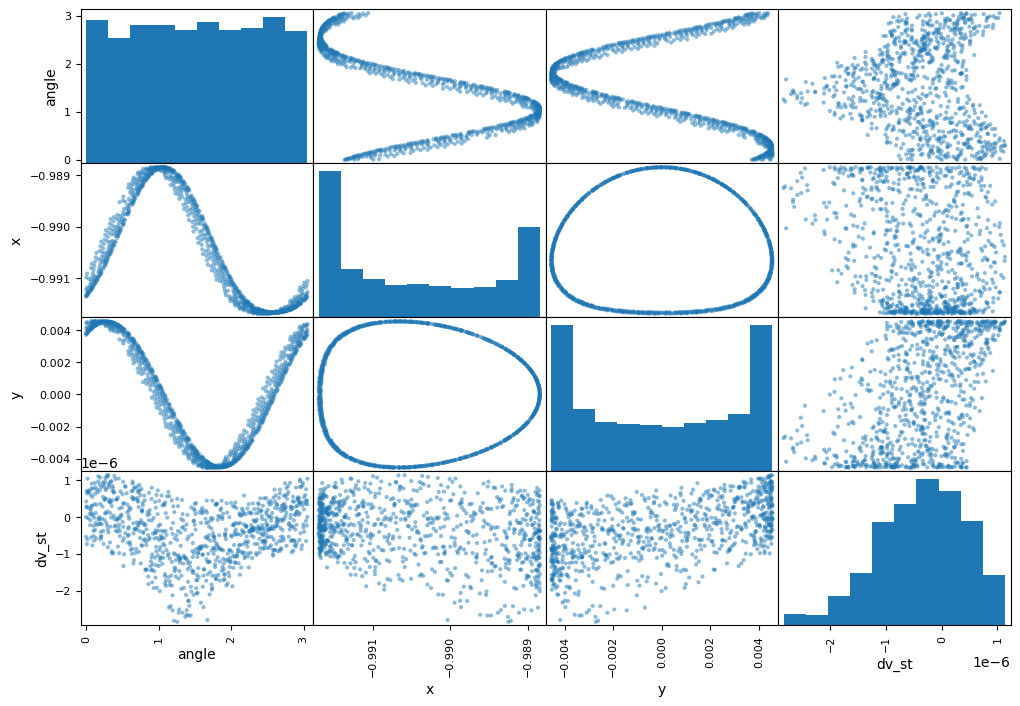

In [411]:
attributes = ["angle", "x", "y", "dv_st"]
scatter_matrix(maneuvers[attributes], figsize=(12, 8))

dv_st is either positively or negatively correlated to state variables (x,y,z,dx,dy,dz) !!

Notice that angle and dv_st are not correlated, but they are nonlinearly related ("V" shape) !!

# Prepare the Data for Machine Learning Algorithms

In [412]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers["dv_st"].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,y,z,dx,dy,dz,angle
530,-0.988851,0.000350,-0.001219,0.000321,-0.009040,-0.000143,0.997450
258,-0.990953,-0.004428,0.000039,-0.002627,0.001951,0.002133,1.963051
1059,-0.990317,-0.004449,-0.000468,-0.003251,-0.002049,0.002235,1.548127
840,-0.990529,-0.004538,-0.000302,-0.003141,-0.000826,0.002261,1.696005
483,-0.989425,-0.003186,-0.000931,-0.002721,-0.006451,0.001407,1.433687


In [413]:
# Let's separate the predictors and the labels
maneuvers_test_predictors = maneuvers_test.drop("dv_st", axis=1)
maneuvers_test_labels = maneuvers_test["dv_st"].copy()

# Select and Train a Model

## Training and Evaluating on the Training Set

In [414]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(maneuvers_predictors, maneuvers_labels)

LinearRegression()

In [415]:
# Let's measure this regression model's RMSE on the whole training set
from sklearn.metrics import mean_squared_error
maneuvers_predictions = lin_reg.predict(maneuvers_predictors)
lin_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6.541526663409867e-07

Clearly not a great score: the SD(dv_st) value is 8.e-7, so a typical prediction error of 6.6.e-7 is not great.

In [416]:
# Let’s train a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(maneuvers_predictors, maneuvers_labels)

maneuvers_predictions = tree_reg.predict(maneuvers_predictors)
tree_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

3.0736991138053015e-09

NOW THIS IS MUCH BETTER!!

In [417]:
#Let's try it out on 5 instances from the test set
some_data = maneuvers_test_predictors[10:20]
some_labels = maneuvers_test_labels[10:20]
print("Predictions:", list(tree_reg.predict(some_data)))
print("Labels:", list(some_labels))

Predictions: [-5.707031e-07, 9.643555e-07, -8.554687e-08, 2.320312e-07, -2.4345705000000003e-07, -2.53125e-07, 6.328125e-08, -6.220703e-07, 1e-07, 2.890625e-08]
Labels: [-1.929688e-07, 4.858398e-07, 3.013672e-07, -3.183594e-07, -8.516602e-07, -5.074219e-07, 4.648438e-08, -1.371973e-06, 1.757812e-07, -3.332031e-07]


In [418]:
# Let’s train a RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(maneuvers_predictors, maneuvers_labels)

maneuvers_predictions = forest_reg.predict(maneuvers_predictors)
forest_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

2.618628341637583e-07

## Polynomial Regression

In [419]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
maneuvers_pred_poly = poly_features.fit_transform(maneuvers_predictors)
#print(maneuvers_predictors.head())
#print(maneuvers_pred_poly[0])

In [420]:
lin_reg = LinearRegression()
lin_reg.fit(maneuvers_pred_poly, maneuvers_labels)
maneuvers_predictions = lin_reg.predict(maneuvers_pred_poly)
lin_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.0633391543670328e-07

## SVM Regression

In [421]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2)
svm_poly_reg.fit(maneuvers_predictors, maneuvers_labels)
maneuvers_predictions = svm_poly_reg.predict(maneuvers_predictors)
svm_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

9.239371770910704e-07

## Cross-validation

Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [422]:
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor()
scores = cross_val_score(tree_reg, maneuvers_predictors, maneuvers_labels,
scoring="neg_root_mean_squared_error", cv=5)
tree_rmse_scores = -scores

In [423]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [8.86354670e-07 8.60564055e-07 1.01784456e-06 8.73827857e-07
 9.03190592e-07]
Mean: 9.083563468235413e-07
Standard deviation: 5.652388468226588e-08
